# Traffic light classification

For traffic lights classification we're going to use [Bosch Small Traffic Lights Dataset](https://hci.iwr.uni-heidelberg.de/content/bosch-small-traffic-lights-dataset)

## Preparations:

1. Download `dataset_additional_rgb.zip` and all train_rgb archives
2. Unzip all of them to the project folder

## Read the dataset information and create yolov5 file structure

### Read information abot downloaded data and define yolov5 path

In [1]:
import yaml
import os
import imagesize
import matplotlib.pyplot as plt
from glob import glob
import random

YOLOV5_PATH = "../yolov5/"

with open("train.yaml", "r") as stream:
    parsed_yaml=yaml.safe_load(stream)

### Create folder structure for yolov5

In [2]:
!rm -r yolo_data_structure
!mkdir -p yolo_data_structure/images/train
!mkdir -p yolo_data_structure/images/test
!mkdir -p yolo_data_structure/images/val
!mkdir -p yolo_data_structure/labels/train
!mkdir -p yolo_data_structure/labels/test
!mkdir -p yolo_data_structure/labels/val

### Create files in dataset structure

In [3]:
# Get the list of unique labels for yaml specification and future use in .txt files
labels_list = []
for image_info in parsed_yaml:
    for boxes in image_info['boxes']:
        labels_list.append(boxes["label"])
labels_list = sorted(list(set(labels_list)))

# Get filenames and paths for each image for future use in creation of ds structure
list_of_filenames = [file_info['path'].split(os.sep)[-1] for file_info in parsed_yaml]
list_of_imagepaths = [file_info['path'] for file_info in parsed_yaml]

In [4]:
# Define dataset split ratio (75% - train, 15% - val, 15% - test)
total_size_of_dataset = len(parsed_yaml)
size_of_train_subset = int(total_size_of_dataset * 0.75)
size_of_validation_subset = int(total_size_of_dataset * 0.15)
size_of_test_subset = total_size_of_dataset - size_of_train_subset - size_of_validation_subset

# Create dict of filenames and values accordingly to its subset
imagename_to_subset = {}
for list_index, filename in enumerate(list_of_filenames):
    if list_index < size_of_train_subset:
        imagename_to_subset[filename] = "train"
    elif size_of_train_subset <= list_index < size_of_train_subset + size_of_validation_subset:
        imagename_to_subset[filename] = "val"
    else:
        imagename_to_subset[filename] = "test"

In [5]:
# Create yaml-file content and write it to yolov5 directory
yaml_file_content = f"""# Bosch Small Traffic Lights Dataset
path: ../traffic_lights_classification/yolo_data_structure
train: images/train
val: images/val
test: images/test

nc: {len(labels_list)}
names: {labels_list}
"""

with open(os.path.join(YOLOV5_PATH, "bosch_traffic_lights.yaml"), "w") as yaml_yolo_file:
    yaml_yolo_file.write(yaml_file_content)

In [6]:
# Gets the sizes of images and checks them to be the same
all_image_sizes = set([imagesize.get(file_data['path']) for file_data in parsed_yaml])
assert len(all_image_sizes) == 1
image_width, image_height = list(all_image_sizes)[0]

def relative_from_min_max(xmin, xmax, ymin, ymax):
    """Converts absolute bbox coordinates
        in format (xmin, xmax, ymin, ymax)
    to relative yolo coordinates
        in format (x_center, y_center, width, height)
    """
    abs_x_center = xmin + (xmax - xmin) // 2
    abs_y_center = ymin + (ymax - ymin) // 2
    relative_x_center = abs_x_center / image_width
    relative_y_center = abs_y_center / image_height
    relative_box_width = (xmax - xmin) / image_width
    relative_box_height = (ymax - ymin) / image_height
    return (relative_x_center,
            relative_y_center,
            relative_box_width,
            relative_box_height)

def yolov5_txt_from_yaml_data(yaml_data):
    """Takes the Bosch data format and converts to
    yolov5 .txt label format
    """
    yolo_label_file_content = ""
    for box_data in yaml_data['boxes']:
        class_number = labels_list.index(box_data['label'])
        yolo_box_row = "{} {:.5f} {:.5f} {:.5f} {:.5f}\n".format(
            class_number,
            *relative_from_min_max(
                 box_data['x_min'],
                 box_data['x_max'],
                 box_data['y_min'],
                 box_data['y_max']
             )
        )
        yolo_label_file_content += yolo_box_row
    return yolo_label_file_content

In [7]:
# This cycle goes through all files,
# collects the information about this file
# converts it to a propper format
# and writes the result to yolo ds structure
for filename, oldpath, yaml_data in zip(
    list_of_filenames, 
    list_of_imagepaths,
    parsed_yaml
    ):
    # Create symlinks to original images
    old_path = os.path.abspath(oldpath)
    new_path = (os.path.join(
        os.path.abspath("yolo_data_structure"),
        "images",
        imagename_to_subset[filename],
        filename))
    os.symlink(old_path, new_path)
    # Create labels annotations
    labels_filepath = (os.path.join(
        os.path.abspath("yolo_data_structure"),
        "labels",
        imagename_to_subset[filename],
        filename[:-4] + ".txt"))
    yolo_label_file_content = yolov5_txt_from_yaml_data(yaml_data)
    with open(labels_filepath, "w") as txt_lablel_file:
        txt_lablel_file.write(yolo_label_file_content)

## Run this command from the yolov5 dir:

```nohup python train.py --img 640 --batch 16 --epochs 20 --data bosch_traffic_lights.yaml --weights yolov5m.pt --project ../traffic_lights_classification --name yolov5_run &```

Now the model is in project directory. All metricts are in the file: `./yolov5_run/results.csv`

## Run detection on the test subset:

```nohup python detect.py --weights ../traffic_lights_classification/yolov5_run/weights/best.pt --source ../traffic_lights_classification/yolo_data_structure/images/test/ --project ../traffic_lights_classification --name yolov5_test_detection &```

### Plot the result

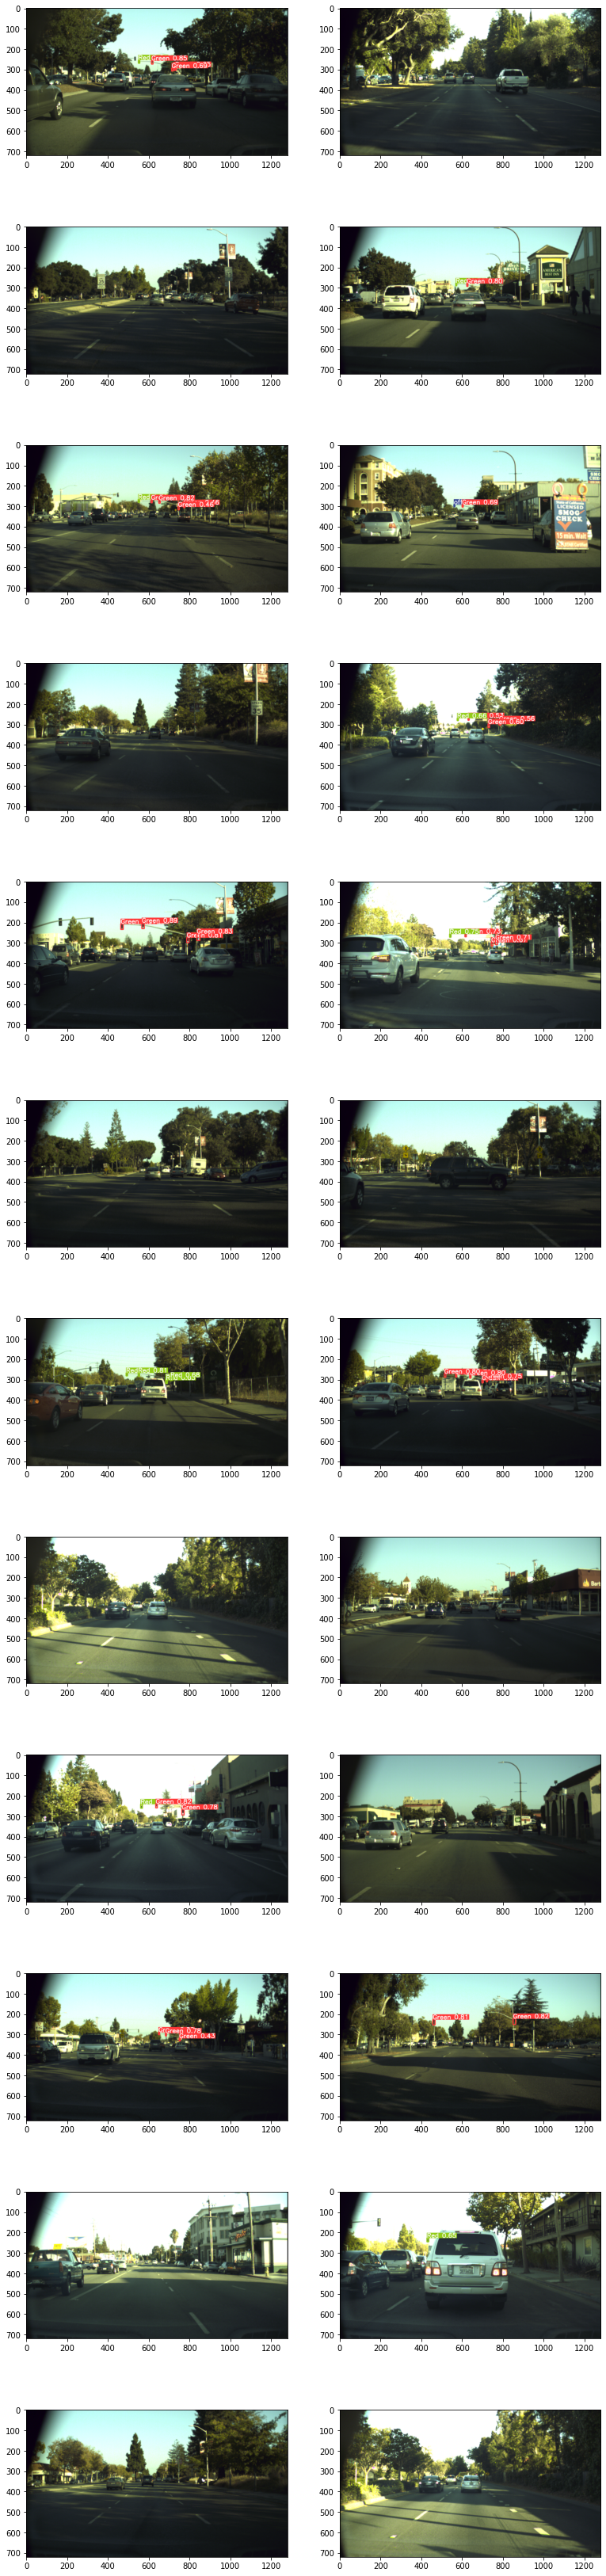

In [76]:
images_to_plot = random.choices(glob("yolov5_test_detection/*"), k=24)

fig, axs = plt.subplots(12,2, figsize=(13,60))
for ax, im_path in zip(axs.flatten(), images_to_plot):
    im = plt.imread(im_path)
    ax.imshow(im)